In [1]:
import sys
sys.path.insert(1, '../')
from graphsemnet.gsn import compute_nmph, spread_activation, rect, compute_adjacency
from scipy.special import expit
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
import pandas as pd

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

NMPH function
$$
h(x) = \begin{cases}
2 x \cdot y_{min}/x_{cp} & x \leq x_{\text{cp}/2}\\
2 x \cdot (y_{cp} - y_{min})/x_{cp} & x_{\text{cp}/2} < x \leq x_{\text{cp}}\\
x \cdot (y_{max} - y_{cp})/(1 - x_{\text{cp}}) & x_{\text{cp}} < x \leq 1
\end{cases}
$$

Let $W_0, \text{ACT}_0$ be the initial conditions

$$
W_d = f\left(W_{d-1} + \lambda h(\text{ACT}_{d-1}^{T}) \circ A \right)
$$

$$
\Delta\text{ACT}_k =  f\left(\sum_{i=0}^{k-1}\gamma^i\text{ACT}_{i}\cdot\prod_{d=0}^{i}W_d\right) \\
$$

- $\Pi$ denotes element-wise multiplication
- $\cdot$ denotes dot-product
- $\text{ACT}_i$ is a row vector
- $f(x)$ is an activation function, in our case a ReLU
- $W$: matrix of (thresholded) weights
- $\gamma$: decay parameter
- $\lambda$: learning parameter

- Todo: extend this with R^i to model second, and third, etc reachability

In [3]:
def noisy_activation(act, sigma_noise=0.1):
    act = np.array(act)
    return rect(act + np.random.normal(scale=sigma_noise, size=act.shape))

In [4]:
def filter_activation(activation):
    a = rect(activation.copy())
    #a = rect(nmph(a))
    a /= a.sum()
    return a.flatten()

In [5]:
depth = 3
gamma = 0.5
alpha = .3
n_iter = 1000
sigma_noise = 0.1

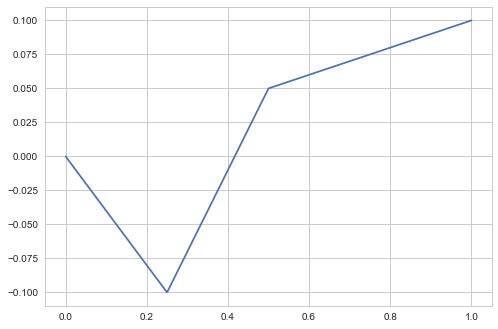

In [6]:
nmph = compute_nmph(-0.1, .5, .05, .1)
x = np.linspace(0, 1, 1000)
y = nmph(x)
plt.plot(x, y);

In [7]:
def run_experiment_subject(gamma, alpha, depth, nmph, n_iter=1000, sigma_noise=0.01):
    winner_iter = []
    # Phase 1: Study
    W = np.zeros((6, 6))
    W[0, 1] = 0.5
    W[0, 2] = 0.5

    W[3, 4] = 0.5
    W[3, 5] = 0.5
    W += W.T

    for i in range(n_iter):
        # Phase 2: Retrieval Practice
        # We want horse
        ACT_pr = np.array([1, .25, 0, 0, 0, 0])[None, :] # we want a row vector
        # Add noise on activation
        ACT_pr = noisy_activation(ACT_pr, sigma_noise=sigma_noise)
        W_ = W
        for _ in range(1):
            Ws, ACT = spread_activation(W_, ACT_pr, nmph, gamma, alpha, depth)
            W_ = Ws[-1]

        # Phase 3: Test
        W_te = Ws[-1]
        ACT_rpplus = noisy_activation(np.array([1, .1, 0, 0, 0, 0])[None, :], sigma_noise)
        ACT_rpminus = noisy_activation(np.array([1, 0, .1, 0, 0, 0])[None, :], sigma_noise)
        ACT_nrp1 = noisy_activation(np.array([0, 0, 0, 1, .1, 0])[None, :], sigma_noise)
        ACT_nrp2 = noisy_activation(np.array([0, 0, 0, 1, 0, .1])[None, :], sigma_noise)

        winners = []
        for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
            _, activation_ = spread_activation(W_te, activation, nmph, gamma, alpha, depth)
            # do not consider the one we activated
            which_active = np.argmax(activation)
            last_activation = activation_[-1]
            # do not look at the category we ping'd
            last_activation[0][which_active] = 0.
            #prob_activation = filter_activation(last_activation, nmph)
            # probabilistic response
            #n_responses = 10
            #responses = np.random.choice(range(6), n_responses, p=prob_activation)
            #winners.append(np.sum(responses == which)/n_responses)
            winners.append((np.argmax(last_activation) == which).astype(int))
            #winners.append((activation_[-1][which] > 0.5).astype(int))
        winner_iter.append(winners)

    winner_iter = np.array(winner_iter)

    #rpplus = np.sum(winner_iter[:, 0] == 1)/n_iter
    #rpminus = np.sum(winner_iter[:, 1] == 2)/n_iter
    #nrp = (np.sum(winner_iter[:, 2] == 4)/n_iter + np.sum(winner_iter[:, 3] == 5)/n_iter)/2.
    return winner_iter

In [43]:
# this works alpha = 0.5
# gamma = 0.5

In [51]:
alpha = 0.5
gamma = 0.8

In [52]:
np.random.seed(432)
sigma_s = 0.2
exp_subj = []
n_subj = 20
n_iter = 1000
sigma_subj = []

for i in range(n_subj):
    print("Subject {0}".format(i))
    # sample noise
    sigma_noise = np.random.normal(scale=sigma_s)
    exp = run_experiment_subject(gamma, alpha, depth, nmph, n_iter=n_iter, sigma_noise=sigma_s)
    exp_subj.append(np.sum(exp, axis=0)/n_iter)
    sigma_subj.append(sigma_noise)

Subject 0
Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19


In [53]:
data = np.vstack(exp_subj)
data = np.hstack((data[:, :2], np.mean(data[:, 2:], axis=1)[:, None]))
df = pd.DataFrame(data, columns=['Rp+', 'Rp-', 'NRp'])
df_ = pd.melt(df)

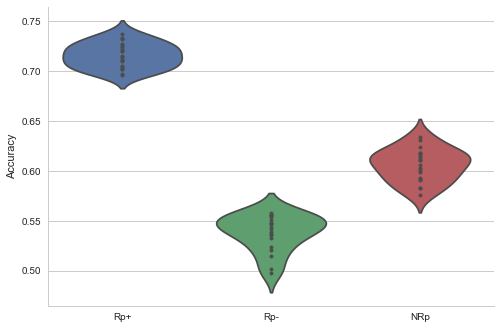

In [54]:
ax = sns.violinplot(x='variable', y='value', data=df_, inner='point')
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
#ax.set_ylim(0, 1)
sns.despine()

In [18]:
exp_subj

[array([ 0.349,  0.253,  0.329,  0.256]),
 array([ 0.329,  0.266,  0.335,  0.258]),
 array([ 0.35 ,  0.283,  0.33 ,  0.263]),
 array([ 0.358,  0.305,  0.326,  0.246]),
 array([ 0.382,  0.274,  0.329,  0.276]),
 array([ 0.363,  0.278,  0.32 ,  0.222]),
 array([ 0.355,  0.265,  0.31 ,  0.255]),
 array([ 0.353,  0.284,  0.359,  0.246]),
 array([ 0.386,  0.295,  0.301,  0.269]),
 array([ 0.354,  0.281,  0.305,  0.276]),
 array([ 0.346,  0.262,  0.324,  0.258]),
 array([ 0.338,  0.27 ,  0.322,  0.269]),
 array([ 0.363,  0.278,  0.332,  0.256]),
 array([ 0.342,  0.301,  0.334,  0.273]),
 array([ 0.355,  0.295,  0.288,  0.246]),
 array([ 0.361,  0.256,  0.34 ,  0.228]),
 array([ 0.324,  0.267,  0.331,  0.267]),
 array([ 0.378,  0.293,  0.331,  0.262]),
 array([ 0.375,  0.266,  0.329,  0.288]),
 array([ 0.324,  0.245,  0.302,  0.256])]

In [9]:
res = np.sum(exp, axis=0)/1000
rp_plus = res[0]
rp_minus = res[1]
nrp = np.mean(res[2:])

<Container object of 3 artists>

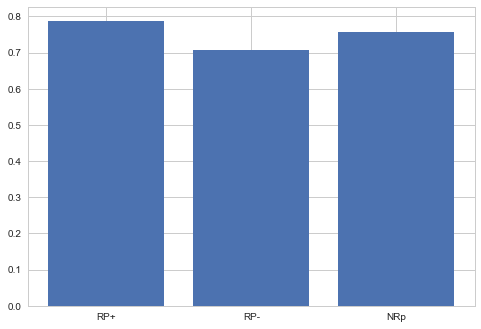

In [10]:
fig, ax = plt.subplots(1, 1)
ax.bar([0, 1, 2], [rp_plus, rp_minus, nrp], tick_label=['RP+', 'RP-', 'NRp'])
#ax.set_ylim([.49, .51]);

In [22]:
gammas = np.linspace(0.1, 1, 10)
depths = np.arange(1, 4)

In [1235]:
from itertools import product, islice

In [1237]:
exps = []
for i, (gamma, d) in enumerate(product(gammas, depths)):
    if i % 10 == 0:
        print(i), 
    exps.append(np.mean(run_experiment(gamma, d, nmph), axis=0))

0
10
20


In [1280]:
def cost_function(exp):
    rp_plus = exp[0]
    rp_minus = exp[1]
    nrp = np.mean(exp[2:])
    cost = (rp_plus/rp_minus) + (nrp/rp_minus) + (rp_plus/nrp)
    return 0 if cost == np.inf else cost

In [1250]:
cost = list(map(lambda x: cost_function(x), exps))

In [1254]:
idx_win = np.argmax(cost)

In [1255]:
cost[idx_win]

3.0275434424394021

In [1256]:
list(product(gammas, depths))[idx_win]

(0.30000000000000004, 2)

In [1258]:
rp_plus = exps[idx_win][0]
rp_minus = exps[idx_win][1]
nrp = np.mean(exps[2:])

In [1262]:
# So these are the parameters we want to keep for gamma and d
gamma, d = list(product(gammas, depths))[idx_win]
print(gamma, d)

0.3 2


In [1263]:
from joblib.parallel import Parallel, delayed

In [1266]:
def compute_onefold(gamma, depth, args_):
    exps = []
    for arg in args_:
        nmph = compute_nmph(*arg)
        exp = run_experiment(gamma, depth, nmph)
        exps.append(exp.mean(axis=0))
    return exps

In [1267]:
# Now we can try to find a good nmph
# this is what we used before: nmph = compute_nmph(-0.1, .5, .1, .4)
n_steps = 5
min_y = np.linspace(-0.4, 0, n_steps)
inflection_x = np.linspace(0.3, 0.6, n_steps)
inflection_y = np.linspace(0, 0.3, n_steps)
y_max = np.linspace(0.5, 0.8, n_steps)

# get all the values
vals = product(min_y, inflection_x, inflection_y, y_max)

n_jobs = 4
step = -(-n_steps**4 // n_jobs)

exps = Parallel(n_jobs=n_jobs)(delayed(compute_onefold)
                          (0.1, 2, islice(vals, step)) for _ in range(n_jobs))
# for i, (gamma, d) in enumerate(product(gammas, depths)):
#     if i % 10 == 0:
#         print(i), 
#     exps.append(run_experiment(gamma, d))

/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in less
/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encounter

In [1272]:
exps = np.vstack(exps)

In [1281]:
exps_cost = np.array(list(map(lambda x: cost_function(x), exps)))

/Users/contematto/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


In [1282]:
np.max(exps_cost)

3.7696109094491801

In [1284]:
win = np.argmax(exps_cost)

In [1285]:
param_win = list(product(min_y, inflection_x, inflection_y, y_max))[win]

In [1286]:
param_win

(-0.40000000000000002, 0.59999999999999998, 0.22499999999999998, 0.5)

In [1287]:
exps[win]

array([ 0.4902,  0.5065,  0.2025,  0.2063])

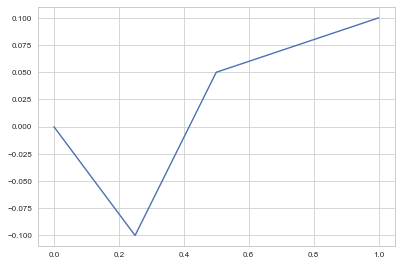

In [19]:
nmph = compute_nmph(-0.1, .5, .05, .1)
x = np.linspace(0, 1, 1000)
y = nmph(x)
plt.plot(x, y);

In [20]:
sns.set_context('paper')

In [84]:
depth = 3
gamma = 0.5
alpha = .3
sigma_noise = 0.1

In [87]:
winner_iter = []
# Phase 1: Study
W = np.zeros((6, 6))
W[0, 1] = 0.5
W[0, 2] = 0.5

W[3, 4] = 0.5
W[3, 5] = 0.5
W += W.T


n_iter = 1

for i in range(n_iter):
    # Phase 2: Retrieval Practice
    # We want horse
    ACT_pr = np.array([1, .25, 0, 0, 0, 0])[None, :] # we want a row vector
    # Add noise on activation
    ACT_pr = noisy_activation(ACT_pr, sigma_noise=sigma_noise)
    W_ = W
    for _ in range(1):
        Ws, ACT = spread_activation(W_, ACT_pr, nmph, gamma, alpha, depth)
        W_ = Ws[-1]

    # Phase 3: Test
    W_te = Ws[-1]
    ACT_rpplus = noisy_activation(np.array([1, .1, 0, 0, 0, 0])[None, :], sigma_noise)
    ACT_rpminus = noisy_activation(np.array([1, 0, .1, 0, 0, 0])[None, :], sigma_noise)
    ACT_nrp1 = noisy_activation(np.array([0, 0, 0, 1, .1, 0])[None, :], sigma_noise)
    ACT_nrp2 = noisy_activation(np.array([0, 0, 0, 1, 0, .1])[None, :], sigma_noise)

    winners = []
    for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
        _, activation_ = spread_activation(W_te, activation, nmph, gamma, alpha, depth)
        # do not consider the one we activated
        which_active = np.argmax(activation)
        last_activation = activation_[-1].copy()
        # do not look at the category we ping'd
        last_activation[0][which_active] = 0.
        #prob_activation = filter_activation(last_activation)
        # probabilistic response
        #print("{0}: Using probs {1}".format(which, np.round(prob_activation, 2)))
        #n_responses = 10
        #responses = np.random.choice(range(len(prob_activation)), n_responses, p=prob_activation)
        #winners.append(np.sum(responses == which)/n_responses)
        winners.append((np.argmax(last_activation) == which).astype(int))
        #winners.append((activation_[-1][which] > 0.5).astype(int))
    winner_iter.append(winners)

winner_iter = np.array(winner_iter)


Loop 1: len(Ws): 2	len(ACT): 2
Loop 2: len(Ws): 3	len(ACT): 3
Loop 1: len(Ws): 2	len(ACT): 2
Loop 2: len(Ws): 3	len(ACT): 3
Loop 1: len(Ws): 2	len(ACT): 2
Loop 2: len(Ws): 3	len(ACT): 3
Loop 1: len(Ws): 2	len(ACT): 2
Loop 2: len(Ws): 3	len(ACT): 3
Loop 1: len(Ws): 2	len(ACT): 2
Loop 2: len(Ws): 3	len(ACT): 3


In [53]:
def plot_activation(Ws, ACT, figsize=(20, 14)):
    n_depth = len(Ws)
    fig, axs = plt.subplots(n_depth, 2, figsize=figsize)
    for W_, ACT_, ax in zip(Ws, ACT, axs):
        sns.heatmap(W_, annot=True, vmin=0, vmax=1, ax=ax[0], square=True)
        sns.heatmap(ACT_, annot=True, vmin=0, vmax=1, ax=ax[1])
    return fig

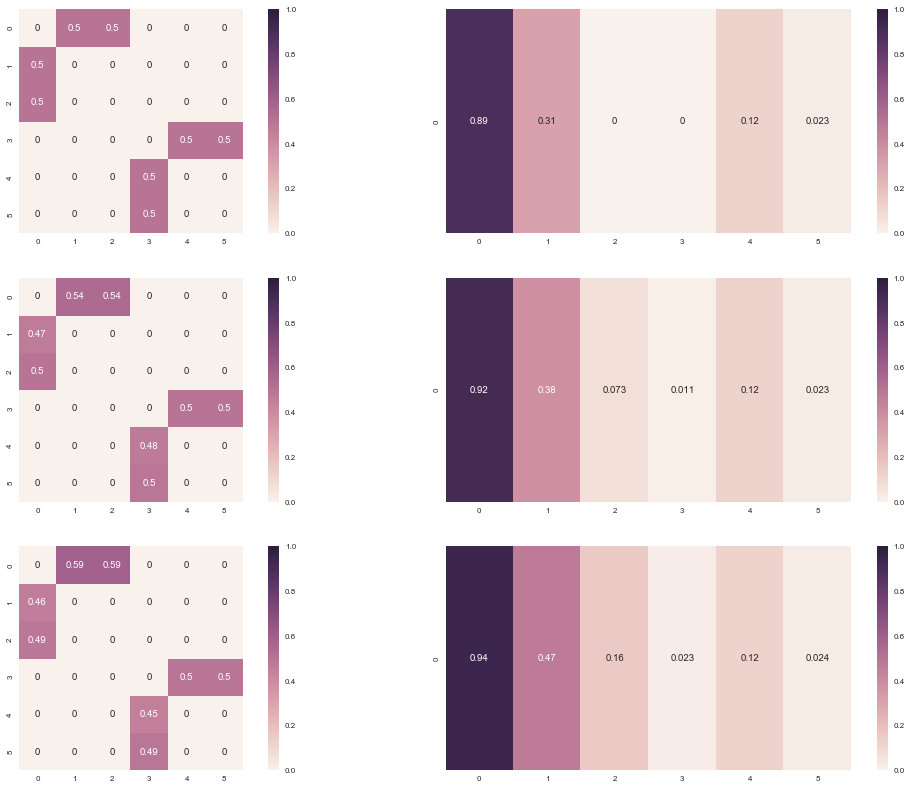

In [54]:
plot_activation(Ws, ACT);

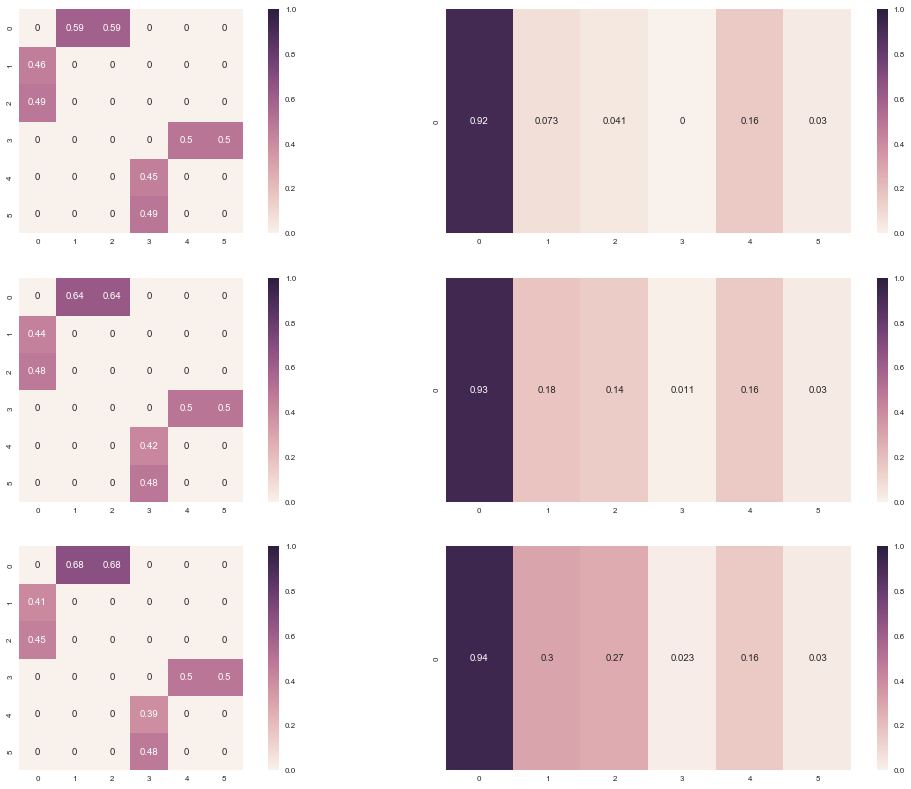

In [57]:
plot_activation(Ws_, activation_);

In [43]:
which_active = np.argmax(ACT_rpplus)
last_activation = activation_[-1].copy()
# do not look at the category we ping'd
last_activation[0][which_active] = 0.
#prob_activation = filter_activation(last_activation, nmph)
# probabilistic response
#n_responses = 10
#responses = np.random.choice(range(6), n_responses, p=prob_activation)
#winners.append(np.sum(responses == which)/n_responses)
winners.append((np.argmax(nmph(last_activation)) == which).astype(int))

In [44]:
which_active

0

In [31]:
n_depth = len(Ws_)
fig, axs = plt.subplots(n_depth, 2, figsize=(20, 14))
for W_, ACT_, ax in zip(Ws, ACT, axs):
    sns.heatmap(W_, annot=True, vmin=0, vmax=1, ax=ax[0], square=True)
    sns.heatmap(ACT_, annot=True, vmin=0, vmax=1, ax=ax[1])

[array([[ 0.97933679,  0.08289122,  0.        ,  0.        ,  0.        ,
          0.00232719]]),
 array([[  9.83730880e-01,   1.97291502e-01,   1.14400278e-01,
           1.69191977e-04,   0.00000000e+00,   2.32719007e-03]]),
 array([[  9.90380367e-01,   3.35759969e-01,   2.52868745e-01,
           3.63335533e-04,   1.89105007e-06,   2.32908112e-03]])]

In [25]:
winner_iter

array([[0, 0, 0, 0]])

In [28]:
spread_activation??

In [29]:
nmph(ACT[0])

array([[ 0.09850315, -0.09492156,  0.        , -0.00586625, -0.00105197,
         0.        ]])

In [27]:
Ws[-1]

array([[ 0.        ,  0.6       ,  0.6       ,  0.        ,  0.        ,
         0.        ],
       [ 0.42872933,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.48024188,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.49892669,
         0.49892669],
       [ 0.        ,  0.        ,  0.        ,  0.49941534,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.49251406,  0.        ,
         0.        ]])

In [42]:
Ws, ACT = spread_activation(Ws[-1], ACT_pr, nmph, gamma, alpha, depth)

In [43]:
len(Ws)

4

In [44]:
print(depth)

3


In [63]:
a = [1, 0.25, 0.10, 0]
b = [0, 0.25, 0.10, 0]